# Pre-processing

Import the JAFFE dataset and extract dominant labels. The image name consists of two parts, the name of model and the dominanat label, eg: KM is the name of model with neutral as dominant feature

In [1]:
from PIL import Image
import glob
from matplotlib import pyplot as plt
raw_images = []
raw_labels = []
for filename in glob.glob('jaffe\images/*.tiff'):
    raw_labels.append(filename[16:18])
    im = Image.open(filename)
    raw_images.append(im)
#make sure images are uploaded correctly
print(len(raw_images))
imgplot = plt.imshow(raw_images[0])
#plot the number of each label
num_neutral = raw_labels.count('NE')
num_happy = raw_labels.count('HA')
num_sad = raw_labels.count('SA')
num_surprised = raw_labels.count('SU')
num_angry = raw_labels.count('AN')
num_disgust = raw_labels.count('DI')
num_fear = raw_labels.count('FE')
print("The number of labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

213
The number of labels are as follows
Neutral : 30  Happy : 31  Sad : 31  Surprised : 30  Angry : 30  Disgust : 29  Fear : 32


### Augmentation

Add random gaussian noise, random rotation and random skewness to the images. Translation wont be used in this project since the image will be cropped to just the face.

In [2]:
import random
import skimage as sk
from skimage import transform as tf
from skimage import img_as_ubyte
from scipy import ndarray
from skimage import util
import numpy as np

def random_noise(image):
    image = np.array(image)
    im = sk.util.random_noise(image)
    im = img_as_ubyte(im)
    return im

def random_rotation(image):
    image = np.array(image)
    random_degree = random.uniform(-15, 15)
    im = (sk.transform.rotate(image, random_degree))
    im = img_as_ubyte(im)
    return im

def random_skew(image):
    shear = random.uniform(-0.2, 0.2)
    afine_tf = tf.AffineTransform(shear = shear)
    im = tf.warp(image, inverse_map=afine_tf)
    im = img_as_ubyte(im)
    return im


C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


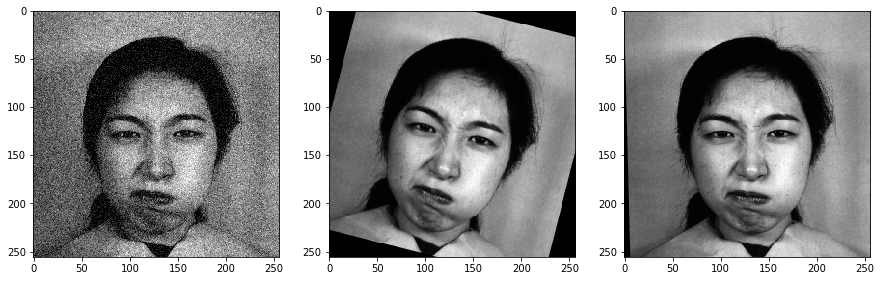

In [3]:
plt.figure(1, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(random_noise(raw_images[0]), cmap = plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(random_rotation(raw_images[0]), cmap = plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(random_skew(raw_images[0]), cmap = plt.cm.gray)

Apply the transformation functions to the dataset to obtain a dataset of 1000 images

In [4]:
augmented_images = raw_images
augmented_raw_labels = raw_labels
size = len(raw_images)
desired_size = 3000
for generated_number in range(desired_size - size):
    #pick a random image from raw images
    r = random.randint(0, size)
    im = raw_images[r]
    #add the label ot augmenetd labels
    augmented_raw_labels.append(raw_labels[r])
    #pick a random trasnformation
    trans = random.randint(1,3)
    if(trans == 1):
        #apply random gaussian noise
        augmented_images.append(random_noise(im))
    elif(trans == 2):
        #apply random rotation
        augmented_images.append(random_rotation(im))
    else:
        #apply random skew
        augmented_images.append(random_skew(im))
print(len(augmented_raw_labels))

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


3000


In [5]:
num_neutral = augmented_raw_labels.count('NE')
num_happy = augmented_raw_labels.count('HA')
num_sad = augmented_raw_labels.count('SA')
num_surprised = augmented_raw_labels.count('SU')
num_angry = augmented_raw_labels.count('AN')
num_disgust = augmented_raw_labels.count('DI')
num_fear = augmented_raw_labels.count('FE')
print("The number of augmented_labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

The number of augmented_labels are as follows
Neutral : 477  Happy : 416  Sad : 408  Surprised : 403  Angry : 430  Disgust : 412  Fear : 454


### Encoding Labels
Transform the labels into a vector of seven numbers [Neutral Happy Sad Surprised Angry Disgust Fear] where an entry of 1 describes the label of the image

[0 1 0 0 0 0 0] descrbies a happy image

In [6]:

labels_names = ['Neutral', 'Happy', 'Sad', 'Surprised', 'Angry', 'Disgust', 'Fear']
augmented_labels = np.zeros((len(augmented_images), len(labels_names)))
for i, value in enumerate(augmented_raw_labels):
    if(value == 'NE'):
        augmented_labels[i][0] = 1
    elif(value == 'HA'):
        augmented_labels[i][1] = 1
    elif(value == 'SA'):
        augmented_labels[i][2] = 1
    elif(value == 'SU'):
        augmented_labels[i][3] = 1
    elif(value == 'AN'):
        augmented_labels[i][4] = 1
    elif(value == 'DI'): 
        augmented_labels[i][5] = 1
    elif(value == 'FE'):
        augmented_labels[i][6] = 1
    else:
        print('Inavalid Label')
print(len(augmented_labels))
print(augmented_labels[0])

3000
[0. 0. 0. 0. 1. 0. 0.]


### Face detection

Number of faces detected: 1


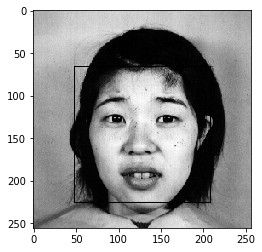

In [7]:
import cv2 
face_cascade = cv2.CascadeClassifier('D:\machine-learning-master\machine-learning-master\projects\Facial Expressions\Project\haarcascade_frontalface_alt.xml')
img = np.array(augmented_images[50])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)


In [8]:
def face_detector(img):
    img = np.array(img)
    return face_cascade.detectMultiScale(img)

### Cropping
before cropping we want to remove images that have zero detected faces or more than one detected face. also remove images that have too small detected faces (some images have detected faces that are not actually faces and are too small regions)

In [9]:
import sys
num_bad_images = 0
cropped_images = []
for i,img in enumerate(augmented_images):
    if(i%10 == 0):
        print('\r{}/{}'.format(i, len(augmented_images)), end="", flush = True)
    faces = face_detector(img)
    if(len(faces) != 1):
        num_bad_images += 1
        augmented_labels = np.delete(augmented_labels, i, axis = 0)
    elif(faces[0][2] < 50 or faces[0][3] < 50):
            num_bad_images += 1
            augmented_labels = np.delete(augmented_labels, i, axis = 0)
    else:
        #crop the image
        x, y, w, h = faces[0]
        array_image = np.array(augmented_images[i])
        cropped_images.append(array_image[y:y+h, x:x+w])
#check if all bad images are removed
if((desired_size == (len(cropped_images) + num_bad_images)) and (desired_size == (len(augmented_labels) + num_bad_images))):
    print('\rall undetectable images removed, {} images remining'.format(len(cropped_images)))
else:
    print('\rot all undetectable images removed please restart kernel')


all undetectable images removed, 2993 images remining


[0. 0. 0. 1. 0. 0. 0.]


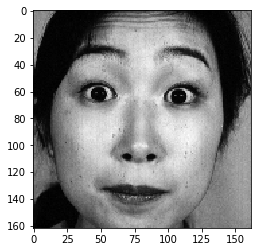

In [10]:
plt.imshow(cropped_images[20], cmap = plt.cm.gray)
print(augmented_labels[20])

In [11]:
#resize all images to largest cropped image size
from PIL import Image
X = [cropped_images[i].shape[0] for i in range(len(cropped_images))]
max_x = max(X)
Y = [cropped_images[i].shape[1] for i in range(len(cropped_images))]
max_y = max(Y)
resized_augmented_images = [Image.fromarray(cropped_images[i]).resize((max_x, max_y), Image.BILINEAR) \
                            for i in range(len(cropped_images))]
print("The final image dataset has a dimensions of {}".format(resized_augmented_images[0].size))

The final image dataset has a dimensions of (184, 184)


### Normalization

In [12]:
def normalize(img):
    img = np.array(img)
    img_min = np.min(img)
    img_max = np.max(img)
    img = (img - img_min) / float(img_max - img_min)
    return img

In [13]:
nomralized_augmented_images = [normalize(resized_augmented_images[i]) for i in range(len(resized_augmented_images))]
print(nomralized_augmented_images[0])

[[0.53811659 0.5426009  0.55156951 ... 0.51121076 0.51569507 0.51121076]
 [0.55605381 0.56502242 0.56950673 ... 0.50224215 0.51121076 0.51569507]
 [0.56950673 0.56053812 0.56053812 ... 0.46188341 0.52466368 0.53363229]
 ...
 [0.24663677 0.30941704 0.26008969 ... 0.53363229 0.5470852  0.55156951]
 [0.26008969 0.28699552 0.24215247 ... 0.52914798 0.5426009  0.56053812]
 [0.2735426  0.25560538 0.24663677 ... 0.51569507 0.53811659 0.57399103]]


### Train_Test Split

[0. 1. 0. 0. 0. 0. 0.]


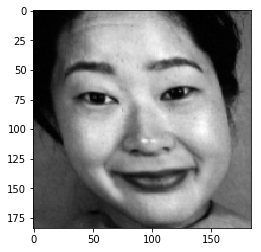

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(nomralized_augmented_images, augmented_labels, test_size = 0.2, random_state = 42)
plt.imshow(X_train[0], cmap = plt.cm.gray)
print(Y_train[0])

### Convert to 4D tensors

In [15]:
def convert_to_tensors(image_array):
    image_array = np.array(image_array)
    tensors = np.resize(image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2], 1))
    return tensors

In [16]:

X_train = convert_to_tensors(X_train)
X_test = convert_to_tensors(X_test)
print(X_train.shape)
print(X_test.shape)

(2394, 184, 184, 1)
(599, 184, 184, 1)


# Training

### Initialize random Hyperparameters 

In [101]:
import random

parameters_grid = {
    'initial_n_filters' : [16, 32, 64, 128],
    'kernel_size' : [2, 3, 4],
    'learning_rate' : list(np.linspace(0.0005, 0.005, 45)),
    'momentum' : list(np.linspace(0.7, 0.9, 10)),
    'batch_size': list(range(10, 100, 10))
}

random_parameters = {K: random.sample(V, 1)[0] for K, V in parameters_grid.items()}

n_iterations = 30

### Creating Model

In [93]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, strides=1,kernel_initializer = 'random_normal', padding='same', 
activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=128, kernel_size=2, strides=1,kernel_initializer = 'random_normal', padding='same', 
    activation='relu')) 
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=256, kernel_size=2, strides=1,kernel_initializer = 'random_normal', padding='same', 
    activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(7, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 184, 184, 64)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 92, 92, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 92, 92, 128)       32896     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 256)       131328    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 135424)            0         
__________

### Create optimizer

In [94]:
opt = RMSprop(lr = 0.001, rho = 0.9)

### Compiling Model

In [95]:
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Train Model

In [102]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  
 
epochs = 40
checkpointer = ModelCheckpoint(filepath='saved_models/.hdf5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
model.fit(X_train, Y_train, 
          validation_split = 0.33,
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=1)

Train on 1603 samples, validate on 791 samples
Epoch 1/40
1603/1603 [==============================] - 6s 4ms/step - loss: 0.0548 - acc: 0.9788 - val_loss: 0.3323 - val_acc: 0.9140

Epoch 00001: val_loss improved from inf to 0.33231, saving model to saved_models/.hdf5
Epoch 2/40
1603/1603 [==============================] - 6s 4ms/step - loss: 0.0406 - acc: 0.9888 - val_loss: 0.9088 - val_acc: 0.8167

Epoch 00002: val_loss did not improve from 0.33231
Epoch 3/40
1603/1603 [==============================] - 6s 4ms/step - loss: 0.0460 - acc: 0.9850 - val_loss: 0.2540 - val_acc: 0.9368

Epoch 00003: val_loss improved from 0.33231 to 0.25400, saving model to saved_models/.hdf5
Epoch 4/40
1603/1603 [==============================] - 6s 4ms/step - loss: 0.0353 - acc: 0.9894 - val_loss: 0.3270 - val_acc: 0.9292

Epoch 00004: val_loss did not improve from 0.25400
Epoch 5/40
1603/1603 [==============================] - 6s 4ms/step - loss: 0.0215 - acc: 0.9938 - val_loss: 0.2738 - val_acc: 0.9368

### Load best model weights

In [103]:
model.load_weights('saved_models/.hdf5')

### Test Model

In [104]:
predicitons = [np.argmax(model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(Y_test, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 93.3222%
